<a href="https://colab.research.google.com/github/ajeyalingam/Pneumonia-Detection/blob/main/pneumonia_detection_old.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### About Dataset

* The dataset consists of training data, validation data, and testing data.
* The training data consists of 5,216 chest x-ray images with 3,875 images shown to have pneumonia and 1,341 images shown to be normal.
* The validation data is relatively small with only 16 images with 8 cases of pneumonia and 8 normal cases.
* The testing data consists of 624 images split between 390 pneumonia cases and 234 normal cases.

### Import libraries

In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, layers
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import layers

import os
import numpy as np
import pandas as np

from random import randint
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

### Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
main_dir = '/content/drive/MyDrive/Data/'
train_data_dir = main_dir + "train/"
validation_data_dir = main_dir + "val/"
test_data_dir = main_dir + "test/"

print("Working Directory Contents:", os.listdir(main_dir))

Working Directory Contents: ['test', 'train', 'val']


In [ ]:
train_n = train_data_dir+'NORMAL/'
train_p = train_data_dir+'PNEUMONIA/'

print("length of cases in training set:",len(os.listdir(train_p)) + len(os.listdir(train_n)))
print("length of pneumonia cases in training set:",len(os.listdir(train_p)))
print("length of normal cases in training set:",len(os.listdir(train_n)))

length of cases in training set: 5216
length of pneumonia cases in training set: 3875
length of normal cases in training set: 1341


The actual sizes of the photos are so high that I set them to size 180x180.

In [ ]:
img_height, img_width  = 180, 180


if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [ ]:
nb_train_samples = 5216
nb_validation_samples = 16
epochs = 12
batch_size = 16

### Upload images

In [ ]:
# Performing Image Augmentation to have more data samples

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


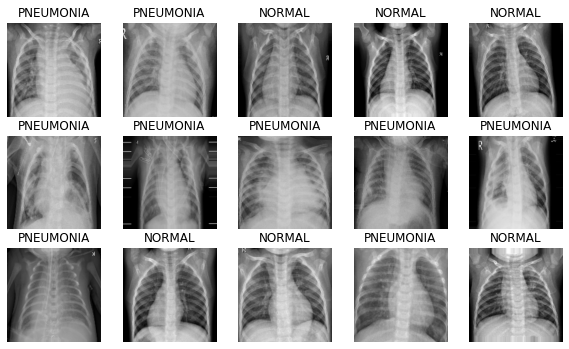

In [ ]:
# Show some images after data augmentation

image_batch, label_batch = next(iter(train_generator))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(15):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch, label_batch)

### Build the CNN

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),  activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 30976)             0

### Train the model

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18091210718007982017, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17703246461818905200
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

### Fit the model

In [ ]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/12
326/326 [==============================] - 1392s 4s/step - loss: 0.3977 - accuracy: 0.8276 - val_loss: 0.9166 - val_accuracy: 0.7500
Epoch 2/12
326/326 [==============================] - 86s 265ms/step - loss: 0.3038 - accuracy: 0.8831 - val_loss: 0.3694 - val_accuracy: 0.8750
Epoch 3/12
326/326 [==============================] - 87s 265ms/step - loss: 0.2609 - accuracy: 0.9043 - val_loss: 2.7211 - val_accuracy: 0.5000
Epoch 4/12
326/326 [==============================] - 87s 265ms/step - loss: 0.2485 - accuracy: 0.9185 - val_loss: 0.7942 - val_accuracy: 0.6875
Epoch 5/12
326/326 [==============================] - 86s 265ms/step - loss: 0.2277 - accuracy: 0.9243 - val_loss: 0.4165 - val_accuracy: 0.8125
Epoch 6/12
326/326 [==============================] - 86s 265ms/step - loss: 0.2234 - accuracy: 0.9260 - val_loss: 1.6184 - val_accuracy: 0.6250
Epoch 7/12
326/326 [==============================] - 86s 264ms/step - loss: 0.2182 - accuracy: 0.9302 - val_loss: 0.7297 - val_acc

In [ ]:
# evaluate the model
scores = model.evaluate_generator(test_generator)

print("Loss of the model: %.2f"%(scores[0]))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))

In [ ]:
prediction = model.predict(test_generator)

In [ ]:
print(prediction[0])
if (prediction[0] > 0.5):
    print("PNEUMONIA")
else:
    print("NORMAL")